In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, ViTTrainer
from src.vit_data import load_cell_cycle_data
    
model_dir = 'output/cell_cycle_24x128_2chan_p1_logfold_simple_20220819_319e'

vit, config = load_model_dir(model_dir, legacy=False)
vit_data = load_cell_cycle_data(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM)
times = sorted(list(set(vit_data.times)))

config_name = "lfc"

dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG, 
                           valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)
print(dataloader.split_repr())

trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=model_dir)
trainer.setup()

53124 4427
53124 4427
Split: time,100; Training: 48697; Validation: 0; Testing: 4427
Resuming from 13900...


In [37]:
from src.rna_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()
trainer.orf_plotter = orf_plotter
trainer.rna_plotter = rna_plotter

In [4]:
from src.attention_analysis import AttentionAnalysis

a_analysis = AttentionAnalysis(trainer=trainer)

In [5]:
a_analysis.compute_attentions(t=None)
a_analysis.resize_imgs()

Reading existing collected attentions output/cell_cycle_24x128_2chan_p1_logfold_simple_20220819_319e/collected_attentions_all.pkl
0/53124 - 00:00:00.03
20000/53124 - 00:00:00.57
40000/53124 - 00:00:01.05
Wrote output/cell_cycle_24x128_2chan_p1_logfold_simple_20220819_319e/imgs_resized.pkl
Wrote output/cell_cycle_24x128_2chan_p1_logfold_simple_20220819_319e/combined_att_imgs.pkl


In [6]:
from src.plot_utils import apply_global_settings
apply_global_settings()

In [7]:
a_analysis.compute_embeddings(t=None, vector=a_analysis.combined_att_imgs_vec)

/Users/trung/opt/anaconda3/envs/chromatin-transformers/lib/python3.9/site-packages/pacmap/pacmap.py:774: UserWarning: Warning: random state is set to 123
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [834]:
combined_atts = a_analysis.combined_att_imgs
mean_att = combined_atts.mean(axis=0)
combined_atts.shape

(53124, 2, 3, 16)

In [990]:
from einops.layers.torch import Rearrange

pivot = Rearrange('(n t) (i) (r) (c) -> n t i r c', t=len(times))
pivoted_atts = pivot(torch.Tensor(combined_atts)).numpy()


In [1010]:
mean_pvt_atts = pivoted_atts.mean(axis=1)
diff_pvt_atts = pivoted_atts.copy()

for i in range(pivoted_atts.shape[1]):
    diff_pvt_atts[:, i] = mean_pvt_atts-pivoted_atts[:, i]

diff_flattened = diff_pvt_atts.reshape((mean_pvt_atts.shape[0], len(times), -1))
eucl_dist = ((diff_flattened**2).sum(axis=2)**0.5)
eucl_dist.shape

(4427, 12)

In [1017]:
att_euc_dist = pd.DataFrame(data=eucl_dist, index=vit_data.orfs[:len(eucl_dist)], columns=times)
att_euc_dist_auto_corr = att_euc_dist.apply(lambda row: compute_row_autocorr_max(row), axis=1)
att_euc_dist_auto_corr

YAL063C     3.712990
YAL062W    13.538736
YAL061W     9.732612
YAL060W    13.054029
YAL059W     8.751751
             ...    
YPR191W    15.716220
YPR196W    28.129684
YPR198W    20.622765
YPR199C    24.530962
YPR201W    46.711096
Length: 4427, dtype: float64

In [1027]:
chrom_dat = vit_data.orfs_data[['name']].copy()
chrom_dat['chrom_att_auto_corr'] = att_euc_dist_auto_corr
chrom_dat.sort_values('chrom_att_auto_corr', ascending=False)

name  chrom_att_auto_corr
orf_name                            
YIR034C    LYS1           122.205624
YGR268C    HUA1           114.109690
YPR158W    CUR1            96.791622
YPR018W    RLF2            93.233782
YDL035C    GPR1            89.253912
...         ...                  ...
YMR116C    ASC1             2.558817
YDL165W   CDC36             2.467326
YDR457W    TOM1             2.398820
YGL229C    SAP4             2.385881
YBR146W   MRPS9             1.669165

[4427 rows x 2 columns]

In [874]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:].max()


In [876]:
def compute_row_autocorr_max(x):
    vals = x[times].astype('float').values
    return autocorr(vals).max()

1.813333369870974e-05

In [912]:
plt_x = a_analysis.plt_data.reset_index().pivot(index='index', columns='time', values='x')
plt_y = a_analysis.plt_data.reset_index().pivot(index='index', columns='time', values='y')

mean_dist_2 = plt_x.copy()

# compute distance from mean in pacmap space
mean_dist_2.loc[:] = ((plt_x.values - plt_x.mean(axis=1).values.reshape((-1, 1)))**2 + \
 (plt_y.values - plt_y.mean(axis=1).values.reshape((-1, 1)))**2)**0.5

# compute max autocorrelation, most cyclic data
df_max_auto_cor = mean_dist_2.apply(lambda row: compute_row_autocorr_max(row), axis=1)

mean_dist_2['max_autocorr'] = df_max_auto_cor

In [913]:
mean_dist_2 = mean_dist_2.sort_values('max_autocorr', 
                        ascending=False).join(vit_data.orfs_data['name'])[['max_autocorr', 'name']]

In [1029]:
lfc_mean_tpm_auto_cor = lfc_mean_tpm.apply(lambda row: compute_row_autocorr_max(row), axis=1)

In [1030]:
mean_dist_2['tpm_autocorr'] = lfc_mean_tpm_auto_cor.loc[mean_dist_2.index.values]
mean_dist_2

max_autocorr     name  tpm_autocorr
index                                         
YIL126W     2727.662245     STH1      0.118163
YDL035C     2509.594775     GPR1      0.213874
YMR117C     2424.643620    SPC24      1.116973
YJL168C     2349.224944     SET2      0.126610
YMR173W     2234.775534    DDR48     10.286749
...                 ...      ...           ...
YJR017C        0.000018     ESS1      0.928834
YPL048W        0.000018     CAM1      0.327632
YDR042C        0.000017  YDR042C      0.446525
YER056C-A      0.000014   RPL34A      0.553520
YGL126W        0.000006     SCS3      1.849370

[4427 rows x 3 columns]

In [924]:
mean_dist_2['tpm_autocorr'] = lfc_mean_tpm_auto_cor.loc[mean_dist_2.index.values]
mean_dist_2.sort_values('tpm_autocorr', ascending=False)

max_autocorr     name  tpm_autocorr
index                                       
YNL327W    401.789465     EGT2     65.521977
YKL164C    141.661188     PIR1     61.777727
YDL227C      1.833204       HO     48.921715
YNR067C    136.825501     DSE4     41.316620
YDL179W     12.934424     PCL9     36.957629
...               ...      ...           ...
YFR048W      3.626749     RMD8      0.015398
YER107C     14.829049     GLE2      0.014225
YNR052C     38.726587     POP2      0.013115
YBR235W    124.097945  YBR235W      0.012392
YCR017C    761.310714    CWH43      0.012013

[4427 rows x 3 columns]

Directory exists. Skipping.
Directory exists. Skipping.


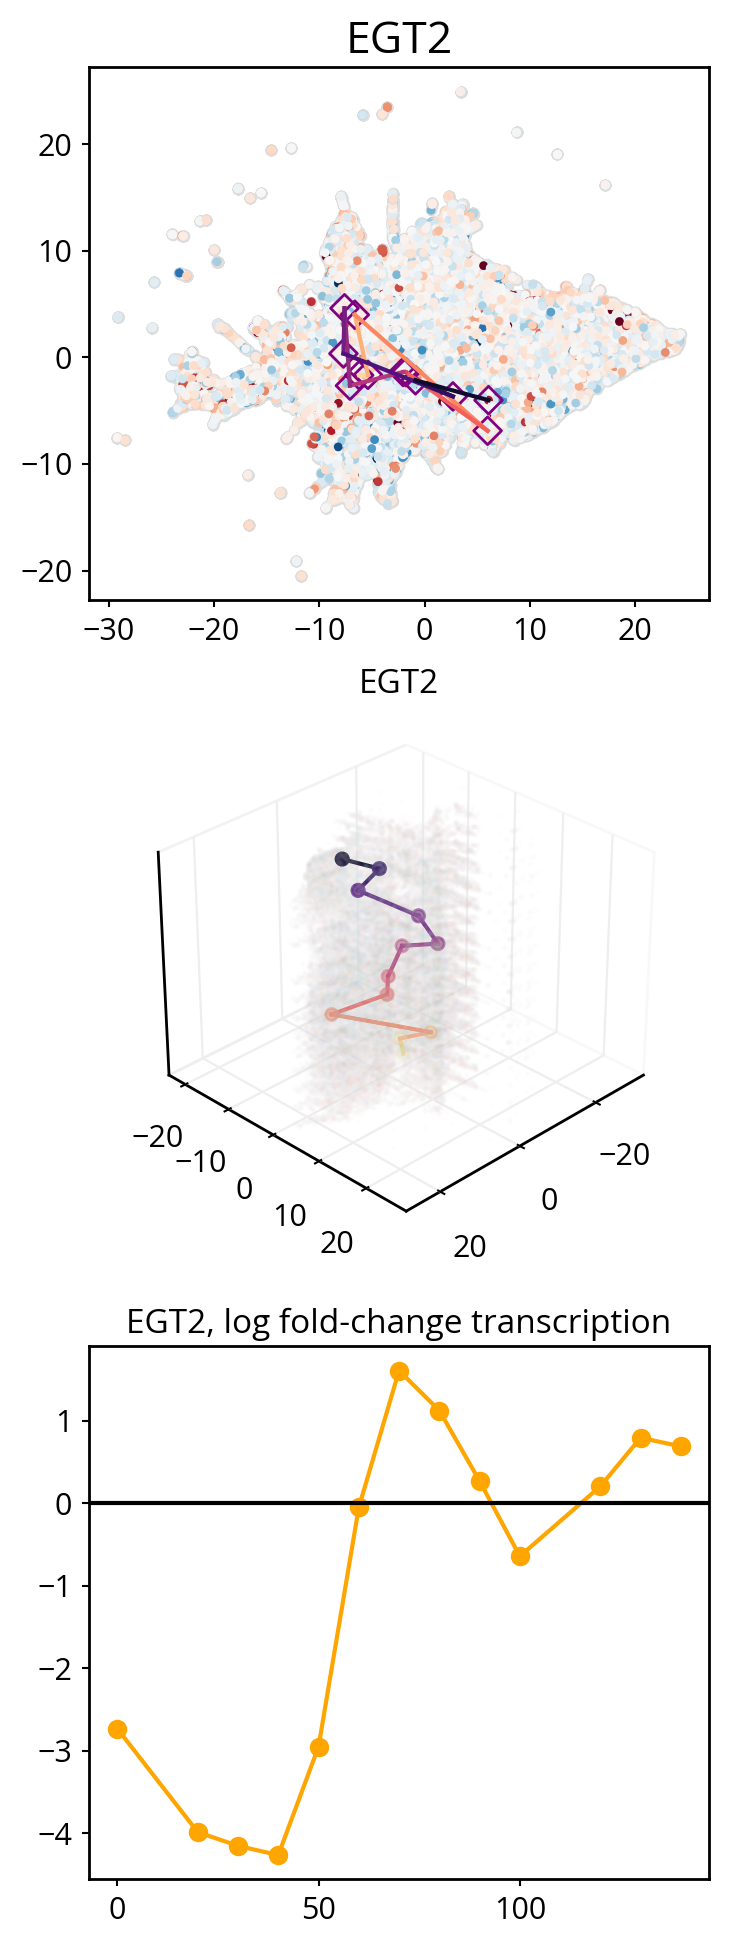

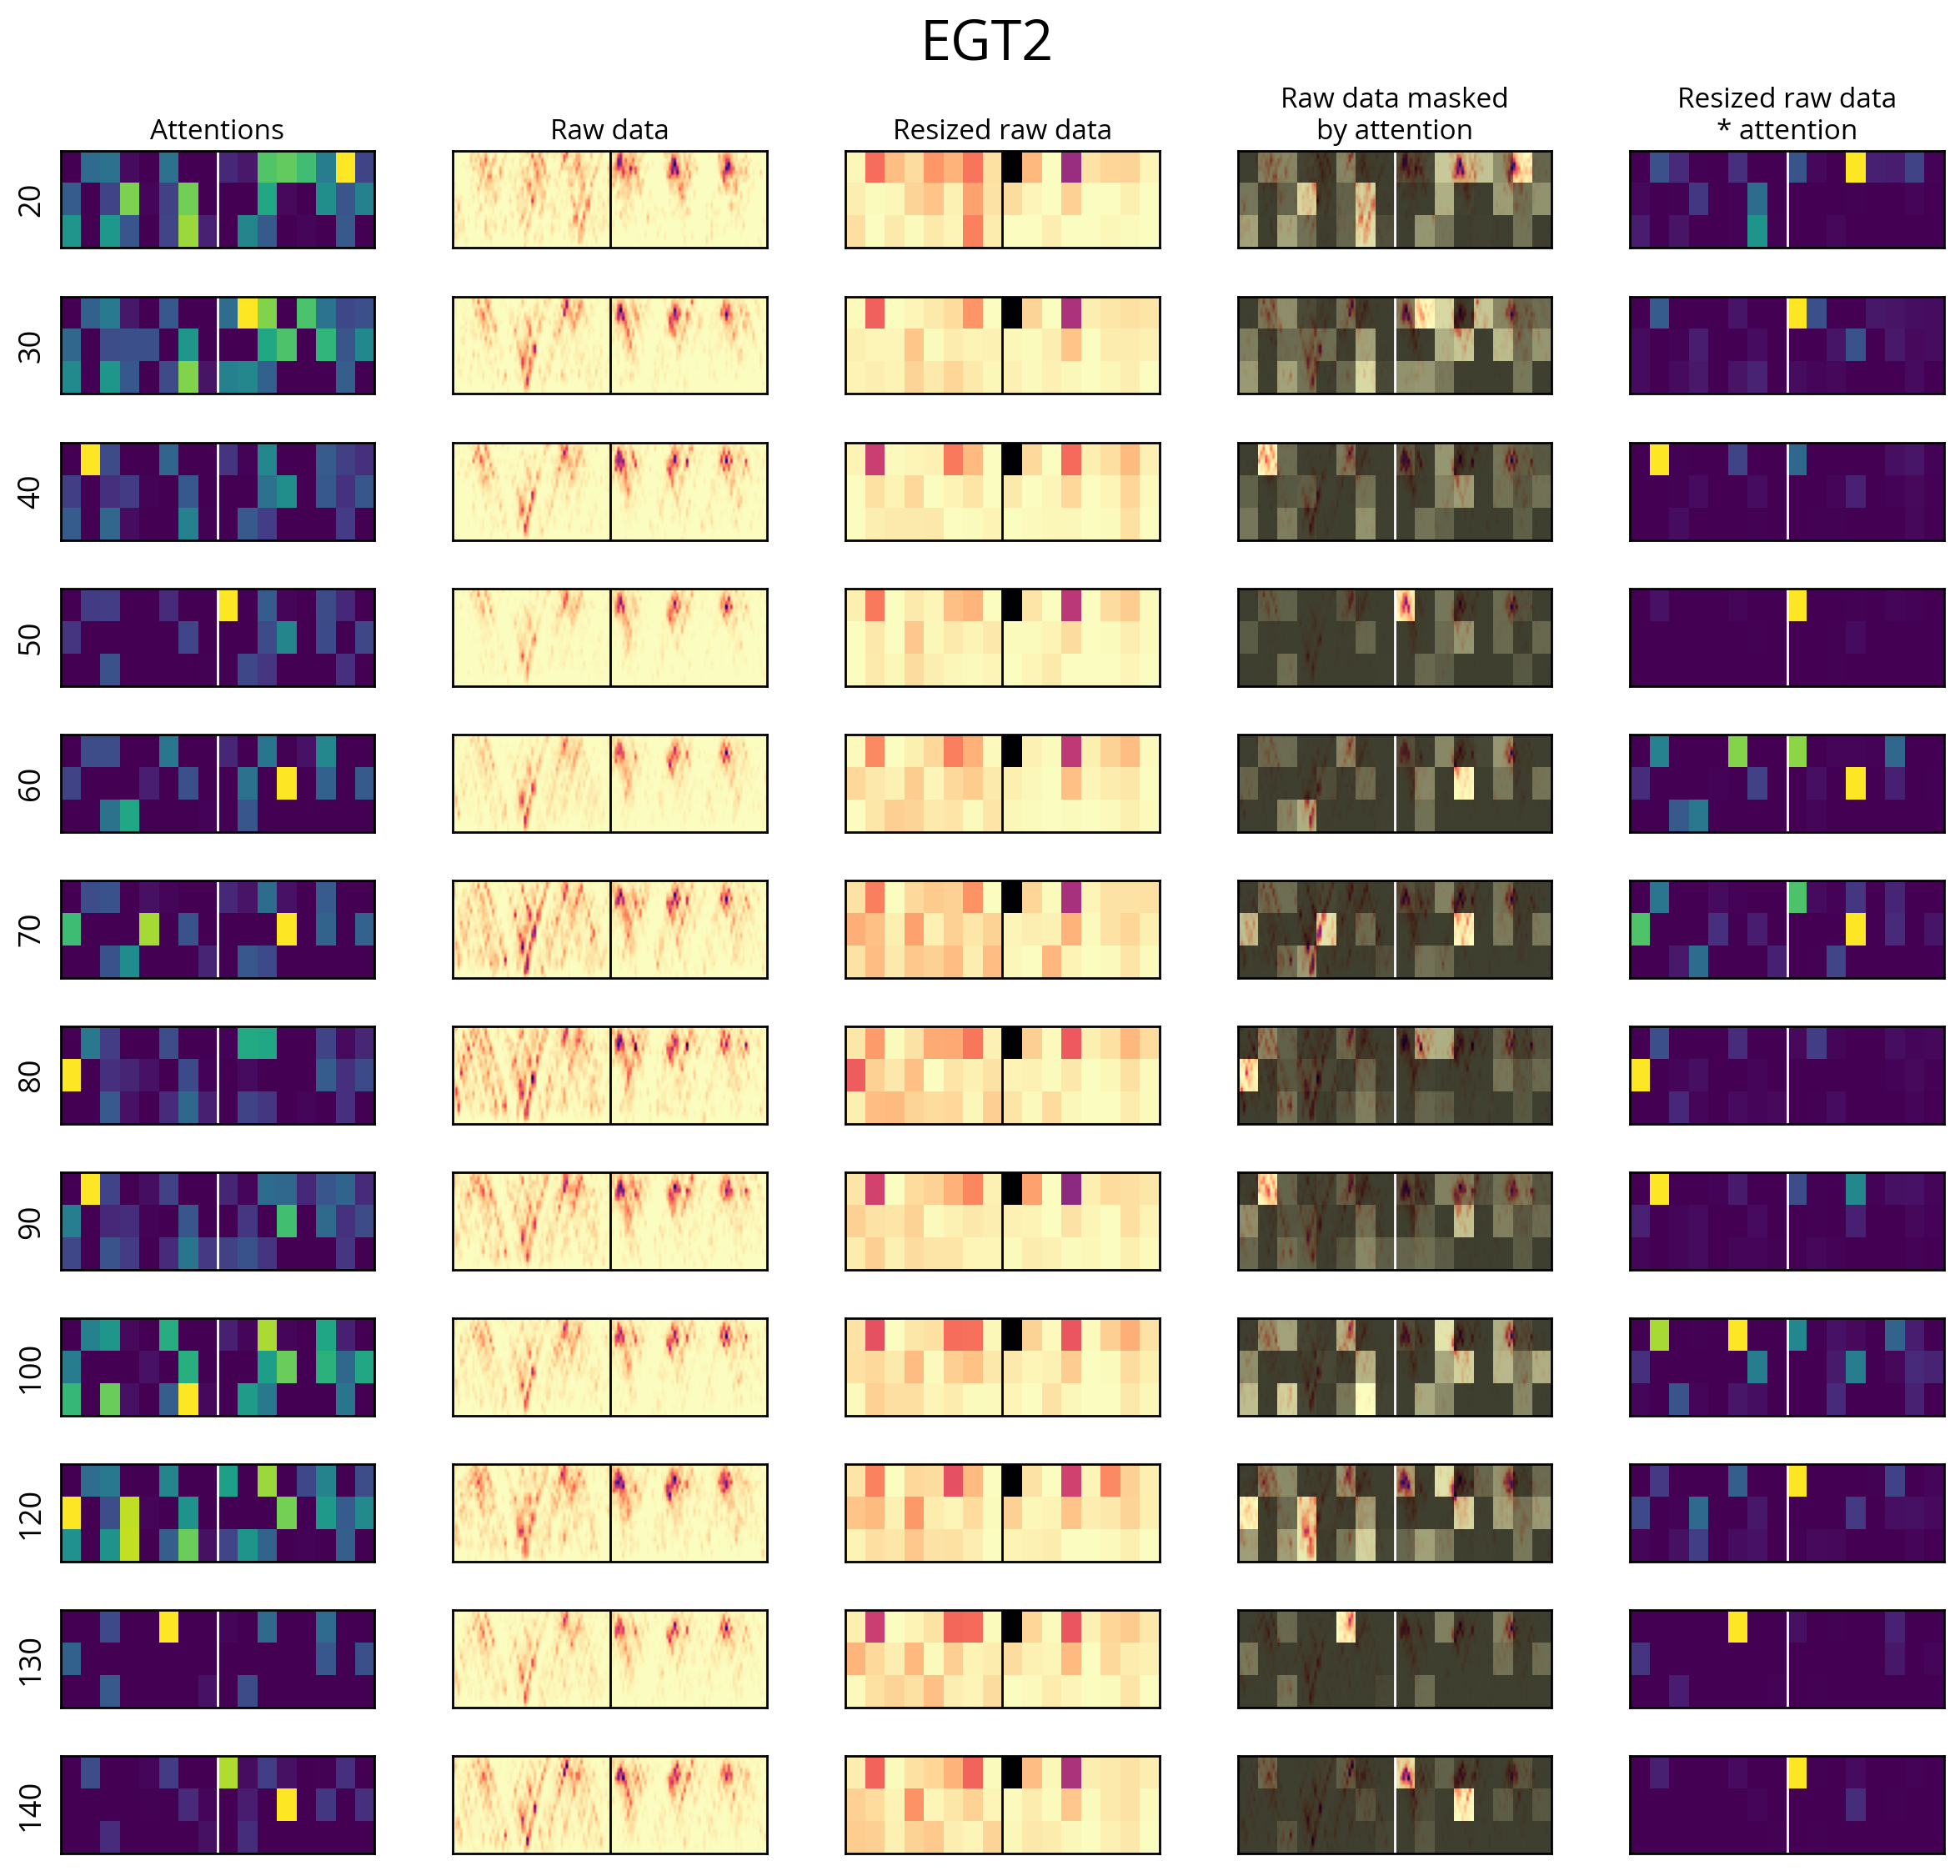

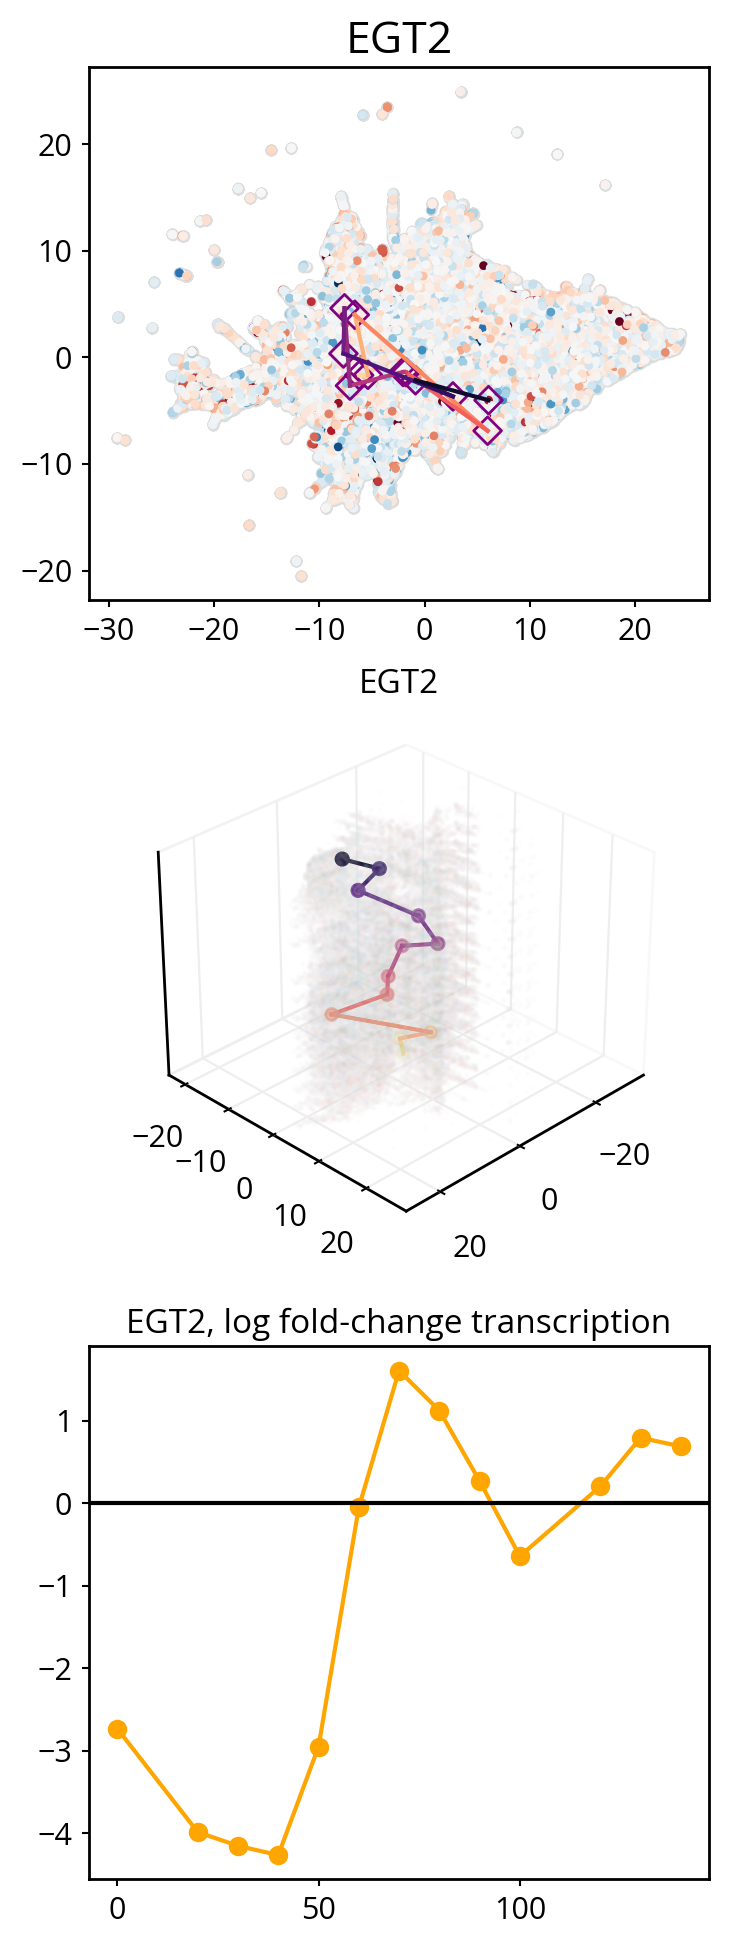

In [922]:
gene_name = 'EGT2'

plot_atts_raw(gene_name)
plot_timecourse(gene_name)

In [9]:
from src.utils import mkdir_safe

def plot_atts_raw(gene_name, index=None):
    times = sorted(list(set(vit_data.times)))

    apply_global_settings(titlepad=5)
    mkdir_safe(f"{trainer.out_dir}/gene_atts")
    orf_name = vit_data.orfs_data[vit_data.orfs_data['name'] == gene_name].index[0]

    fig, axs = plt.subplots(len(times), 5, figsize=(12, 12))
    fig.tight_layout(rect=[0.0, 0., 1.0, 0.9])
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    axs = axs.flatten()

    for i in range(len(times)):
        t = times[i]
        idx = vit_data.index_for(gene_name, t)
        a_analysis.plot_combined_att_img(idx, 1, time=int(t), fig=fig, axs=axs, row=i, titles=(i==0))

    plt.suptitle(gene_name, fontsize=24, y=0.95)
    plt.savefig(f"{trainer.out_dir}/gene_atts/{index}_{gene_name}.png", dpi=150)
    return fig

In [10]:
def plot_timecourse(gene_name, xlim=None, ylim=None, i=None):
    mkdir_safe(f"{trainer.out_dir}/gene_timecourses")
    orf_name = vit_data.orfs_data[vit_data.orfs_data['name'] == gene_name].index[0]
    fig = plt.figure(figsize=(4, 12))
    plt.subplot(3, 1, 1)
    ret = a_analysis.plot_embeddings(selected_orfs=[orf_name], title=gene_name, fig=fig, xlim=xlim, ylim=ylim)

    a_analysis.plot_att_gene_3d(ret, times, gene_name, subplot=312, fig=fig, xlim=xlim, ylim=ylim)

    plt.subplot(3, 1, 3)
    plt.plot(lfc_mean_tpm.columns, lfc_mean_tpm.loc[orf_name], 'o-', c='orange')
    plt.axhline(0, c='black')
    plt.title(f"{gene_name}, log fold-change transcription")
    plt.savefig(f"{trainer.out_dir}/gene_timecourses/{i}_{gene_name}.png", dpi=150)
    return fig

Directory exists. Skipping.
Directory exists. Skipping.


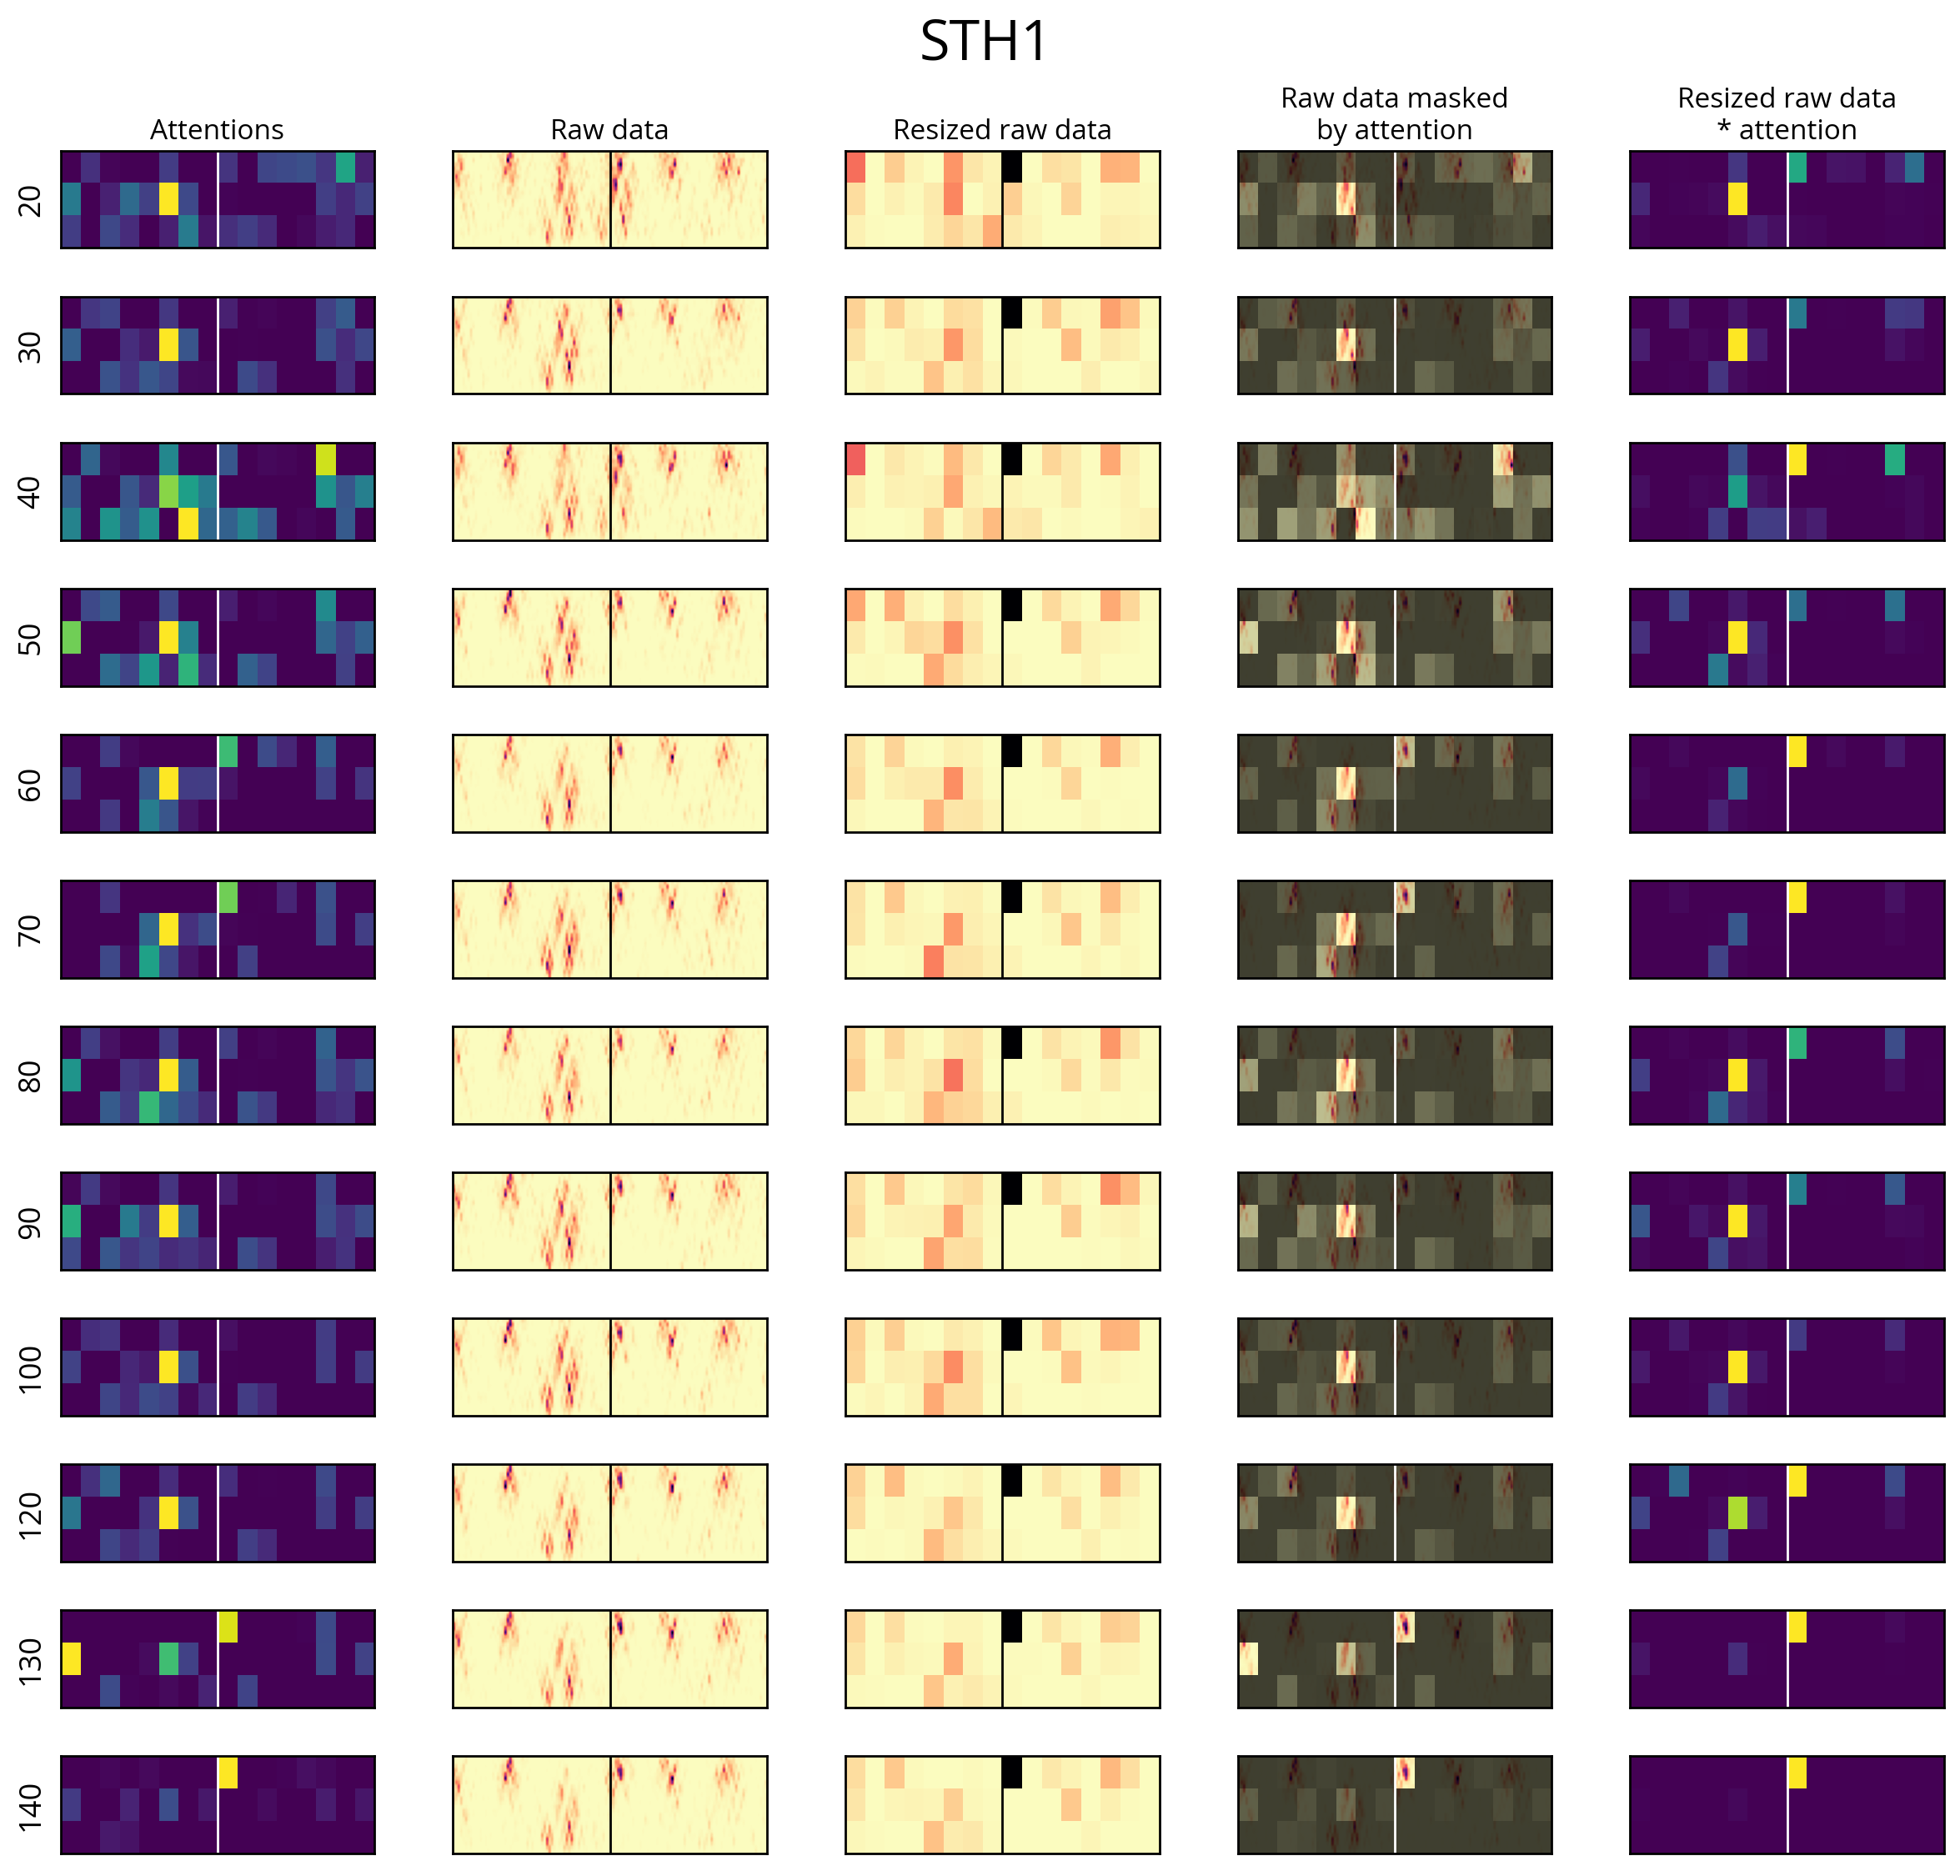

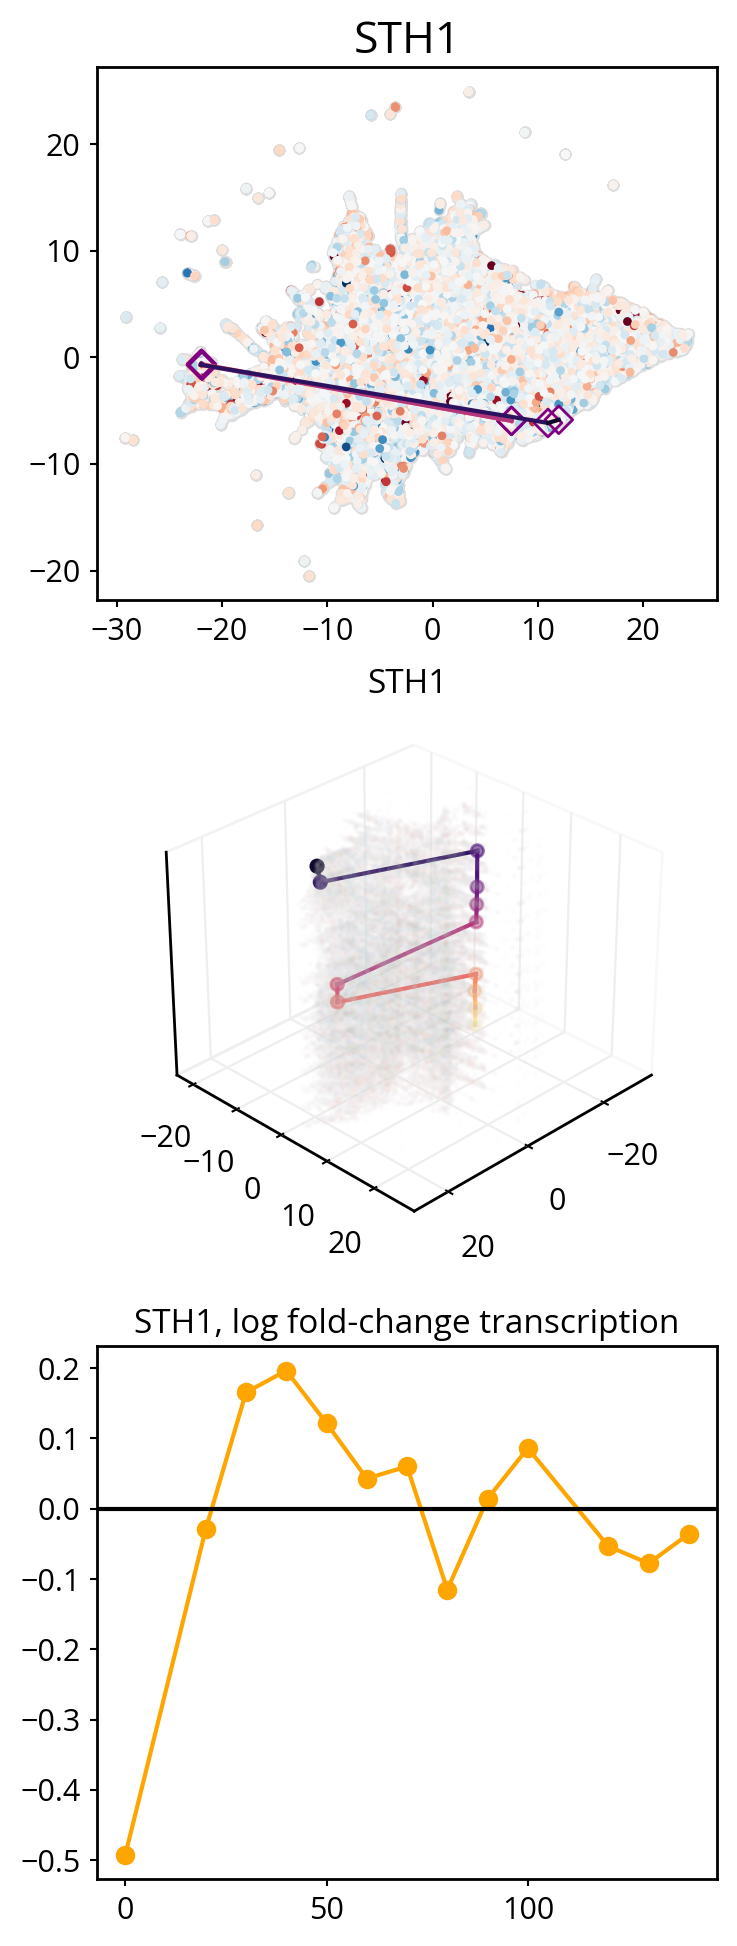

In [896]:
gene_name = 'STH1'

plot_atts_raw(gene_name)
plot_timecourse(gene_name)

Directory exists. Skipping.


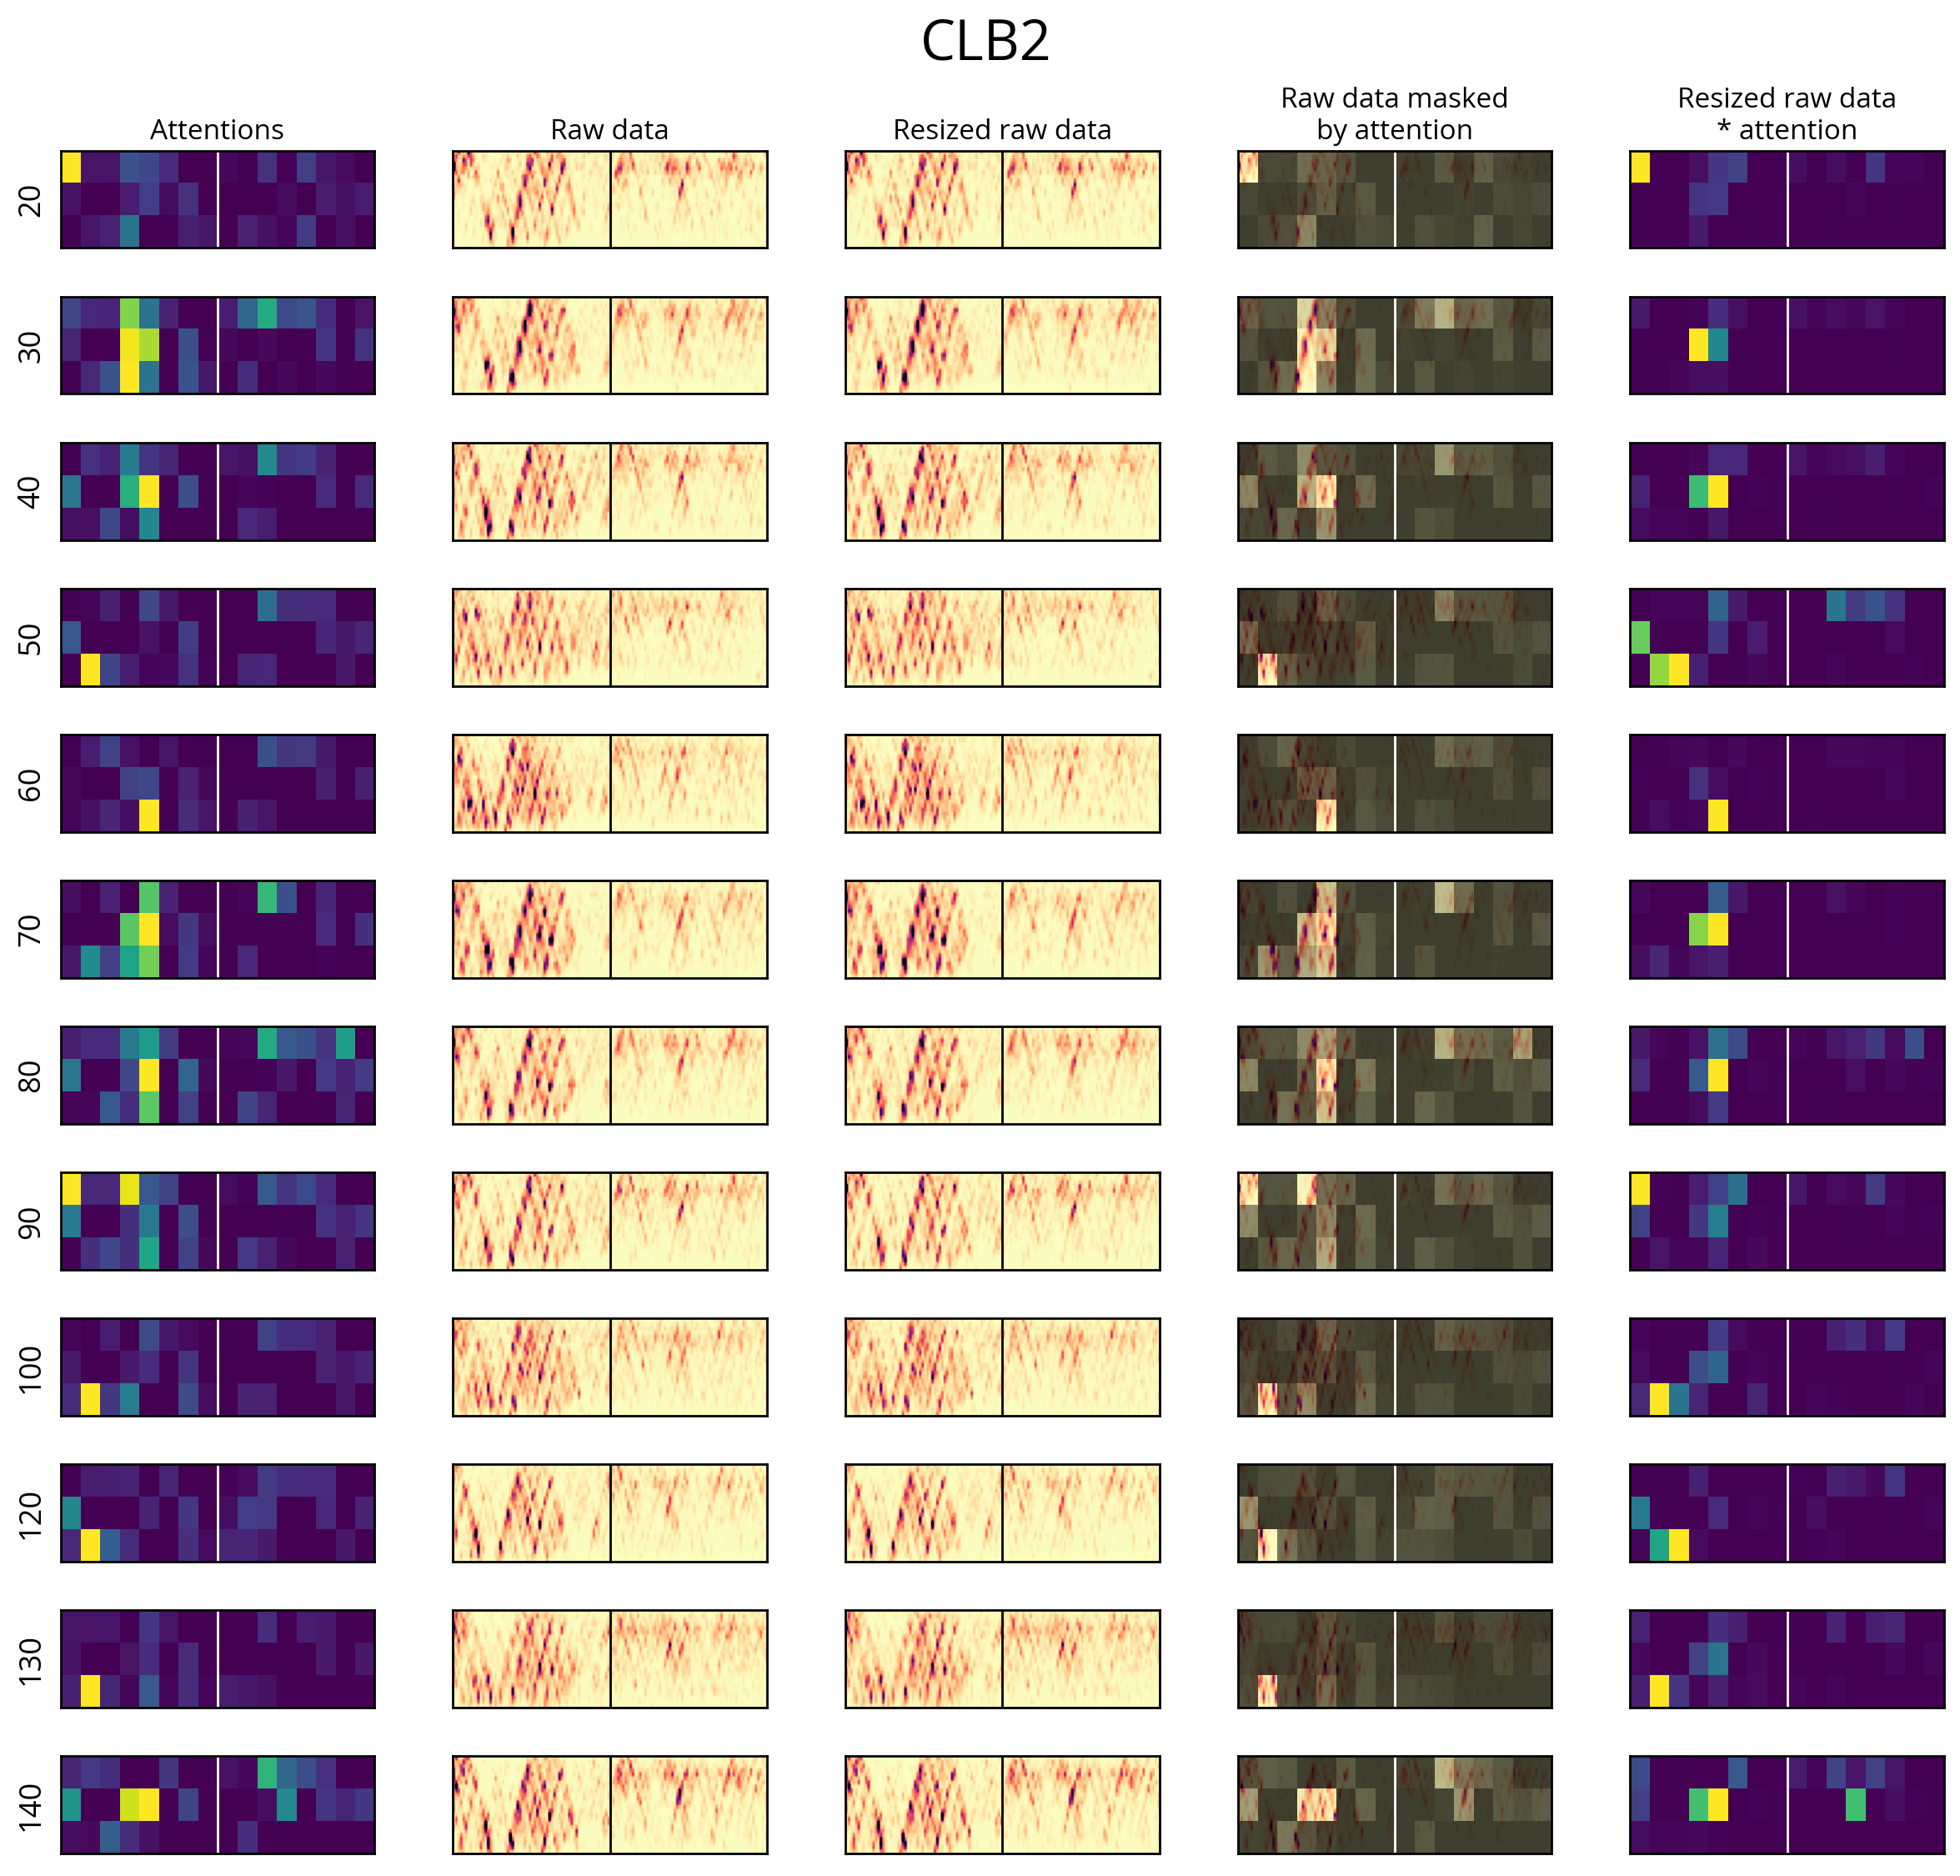

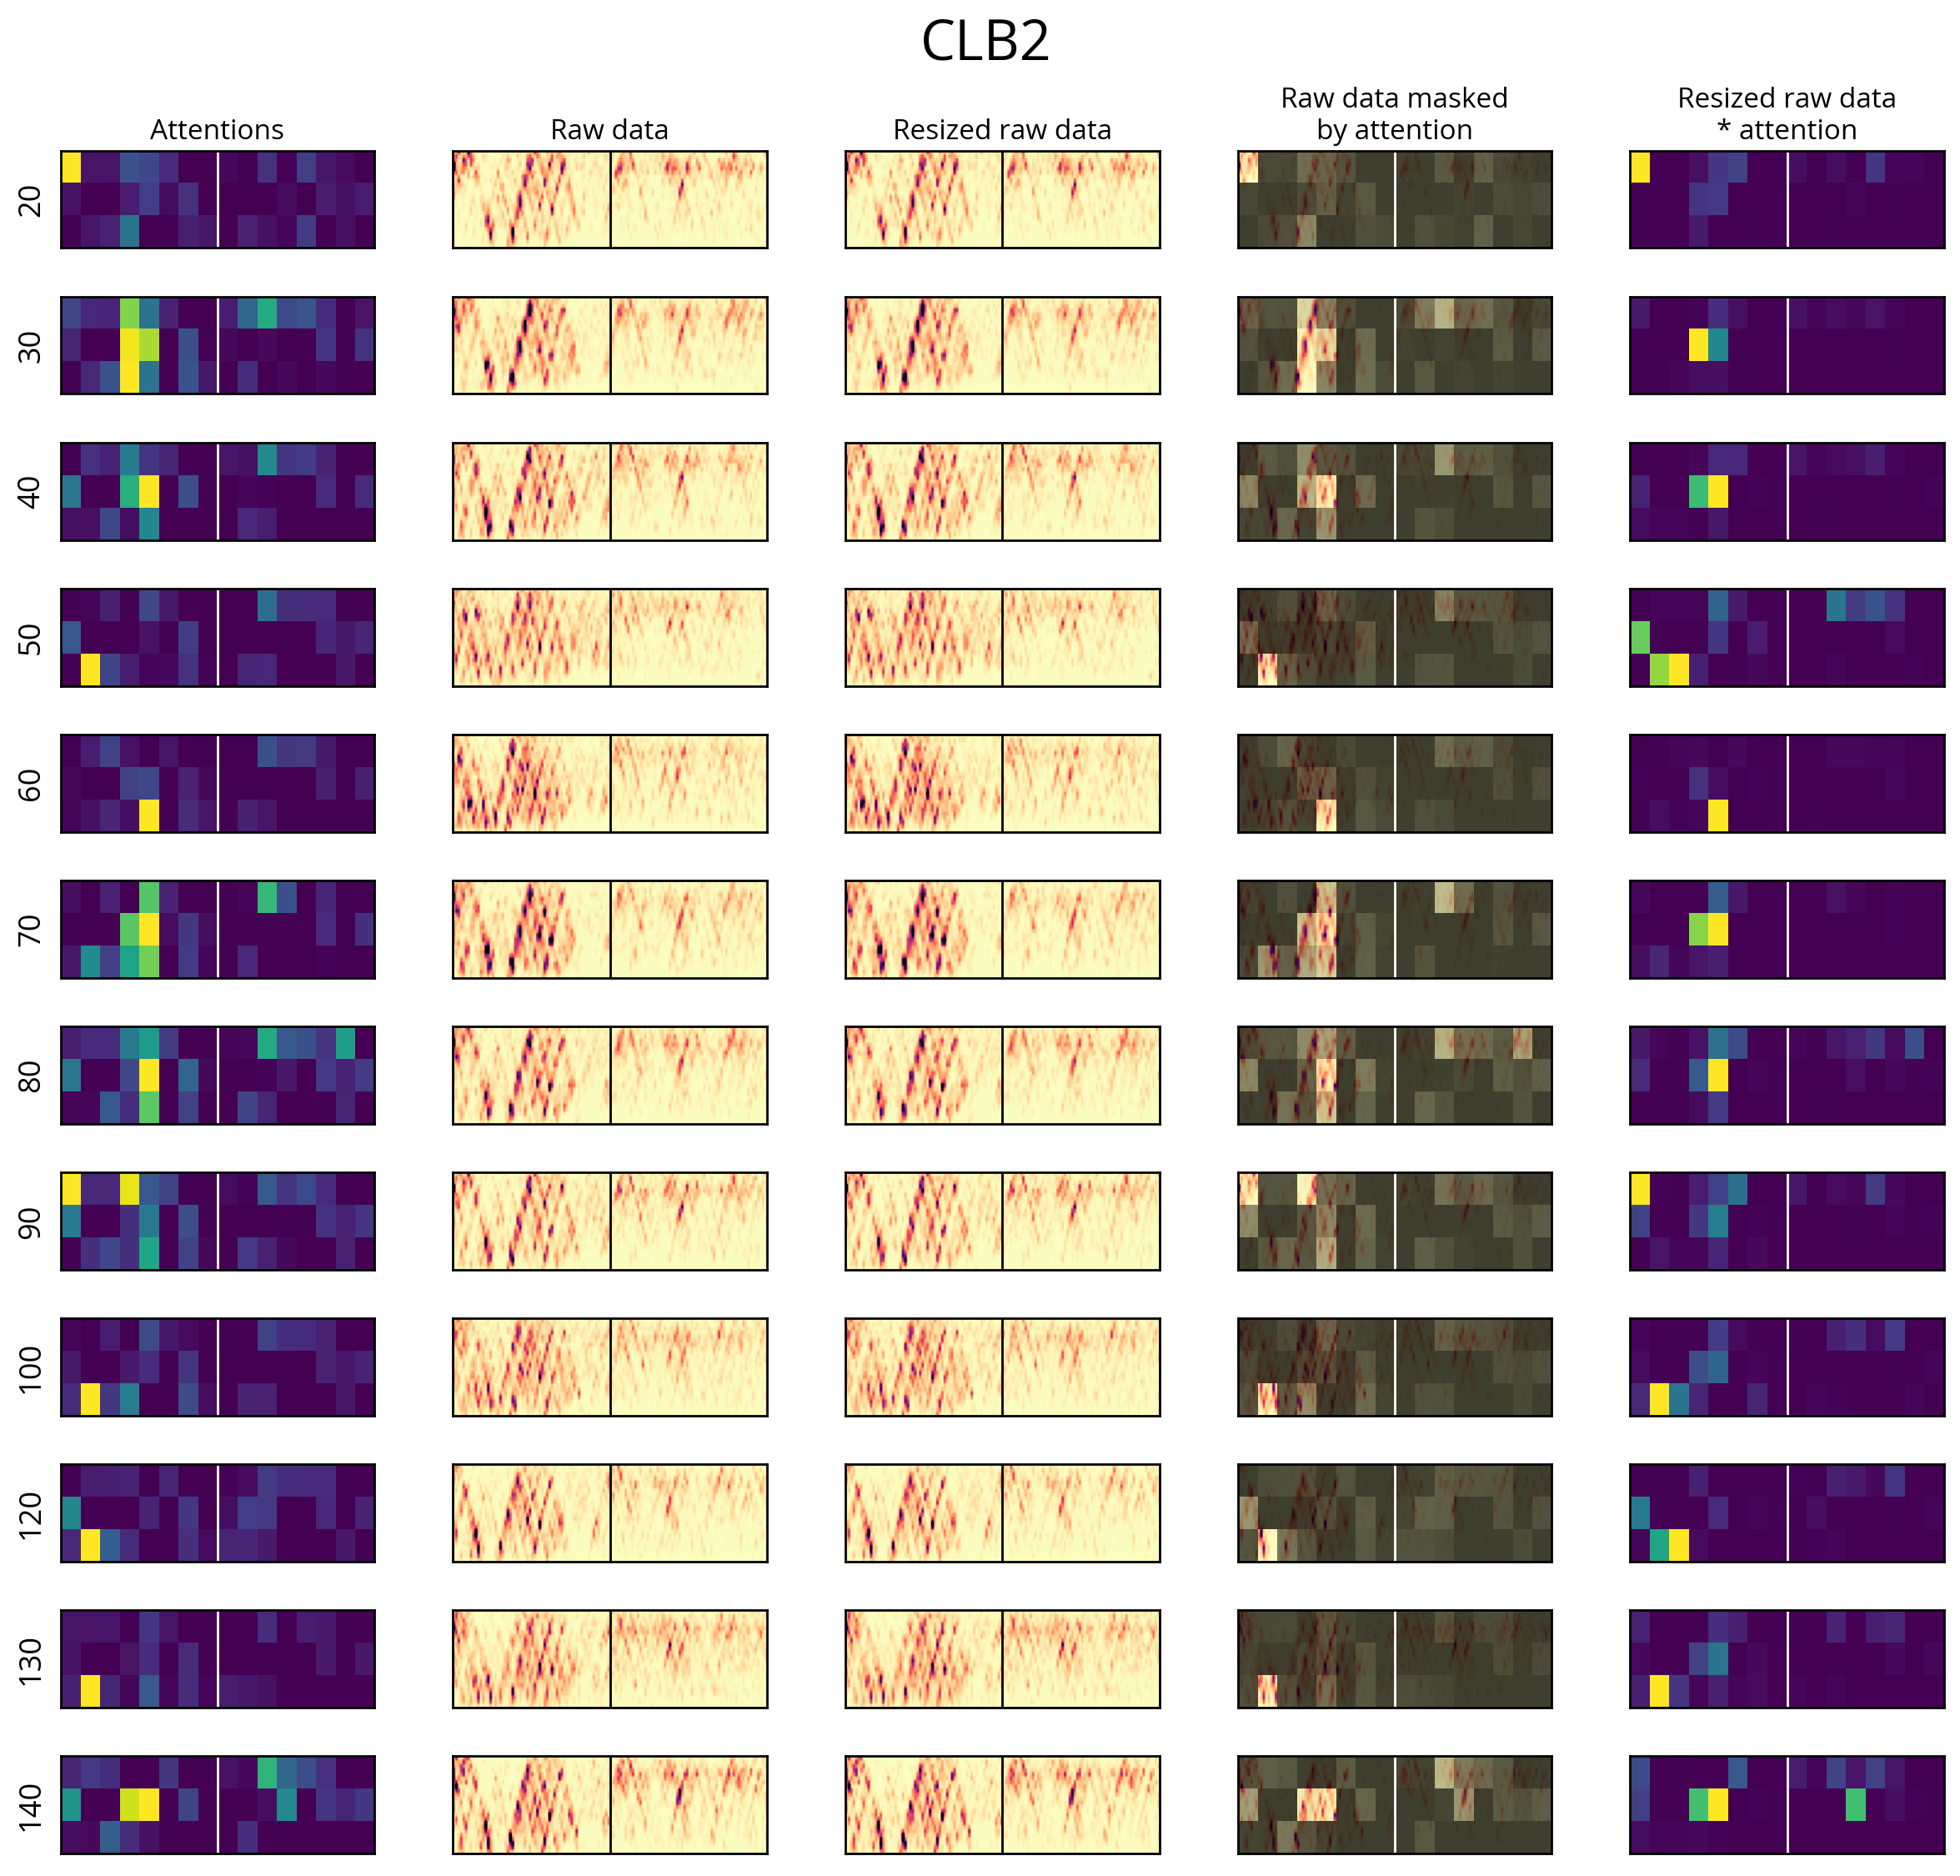

In [19]:
gene_name = 'CLB2'

plot_atts_raw(gene_name)
# plot_timecourse(gene_name)

Directory exists. Skipping.
Directory exists. Skipping.
Directory exists. Skipping.


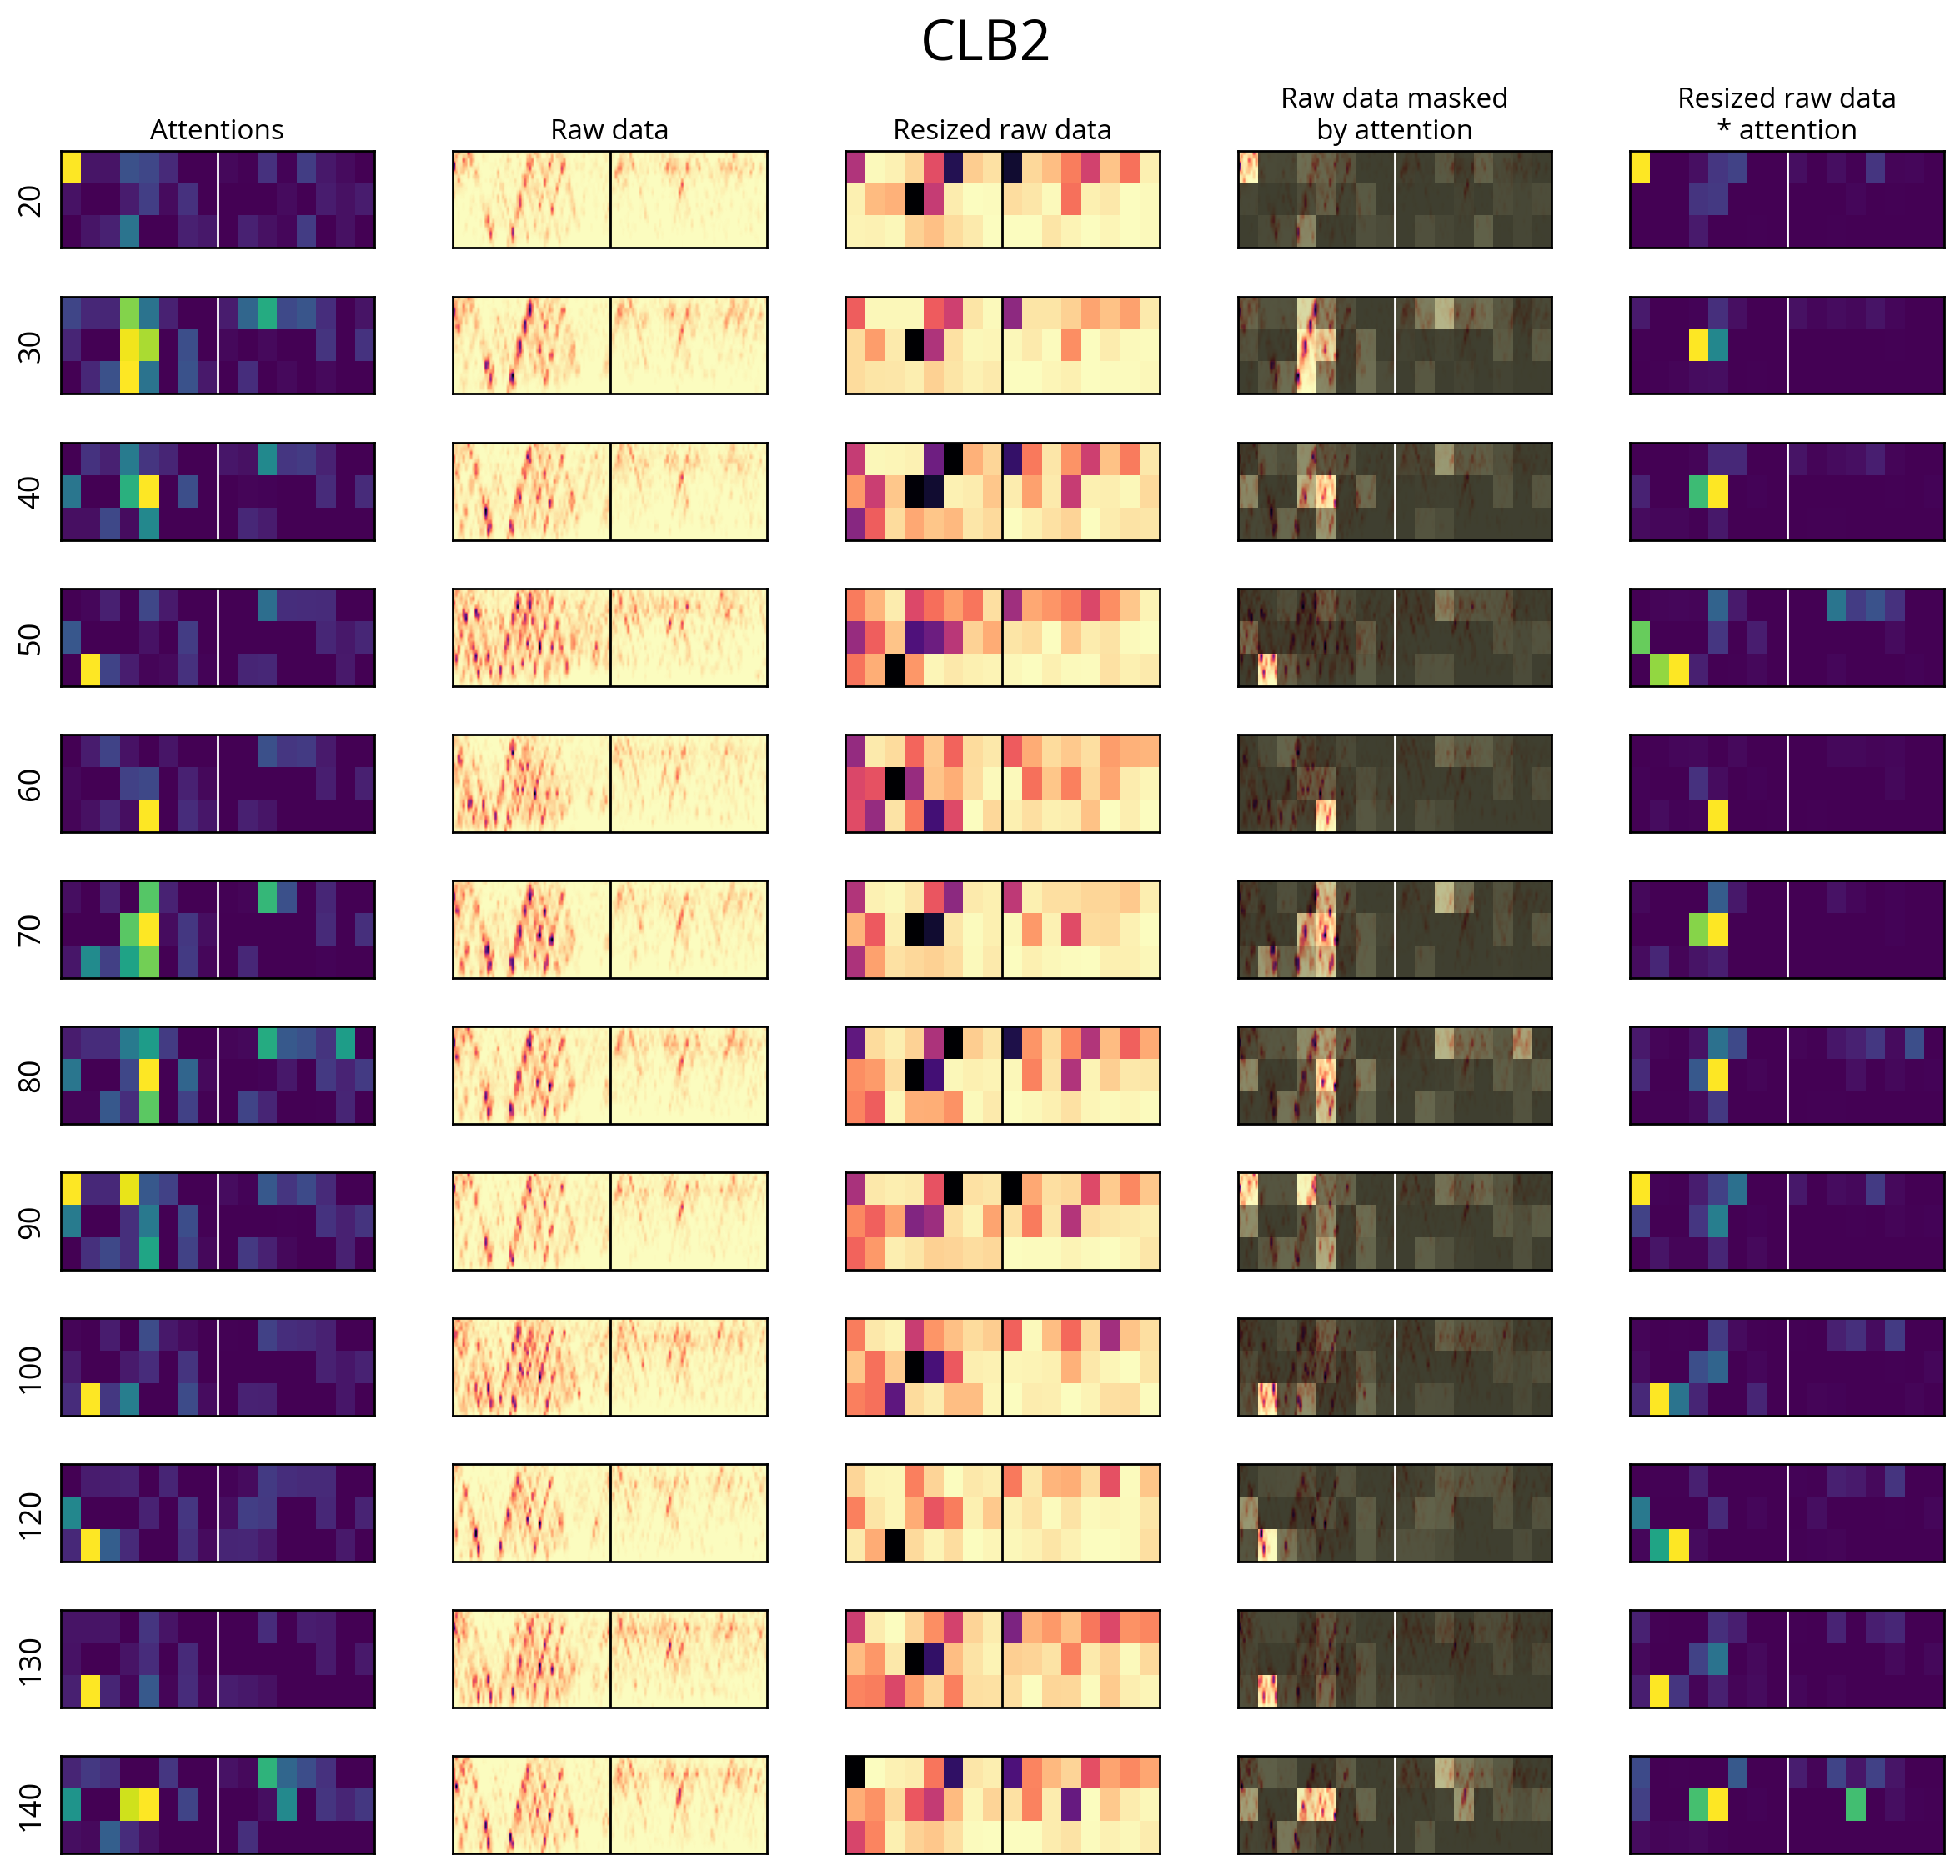

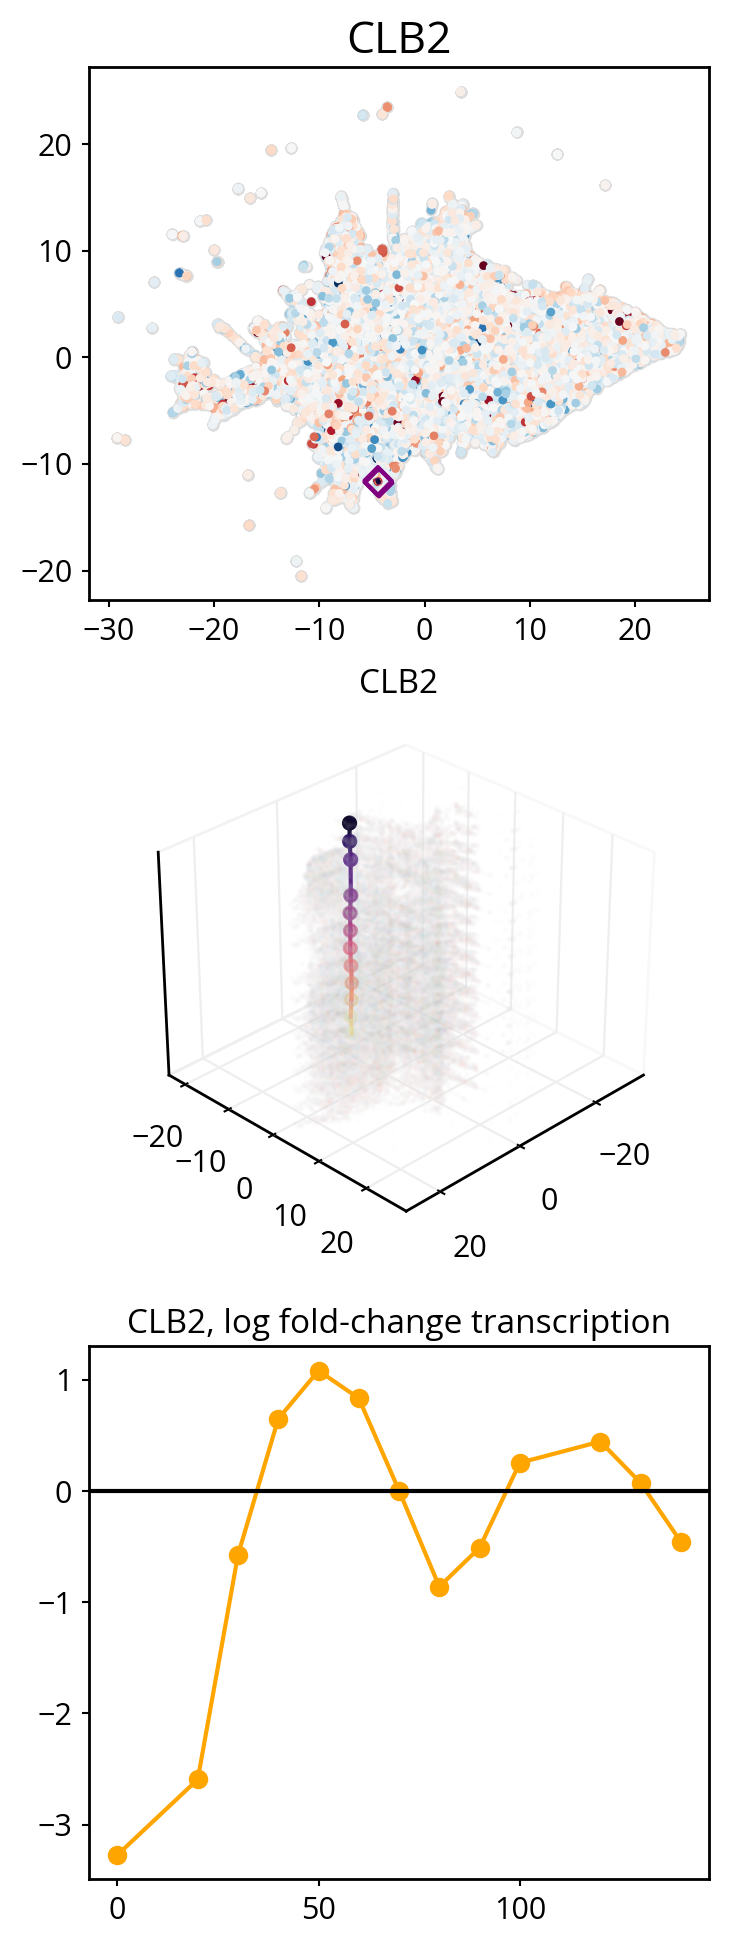

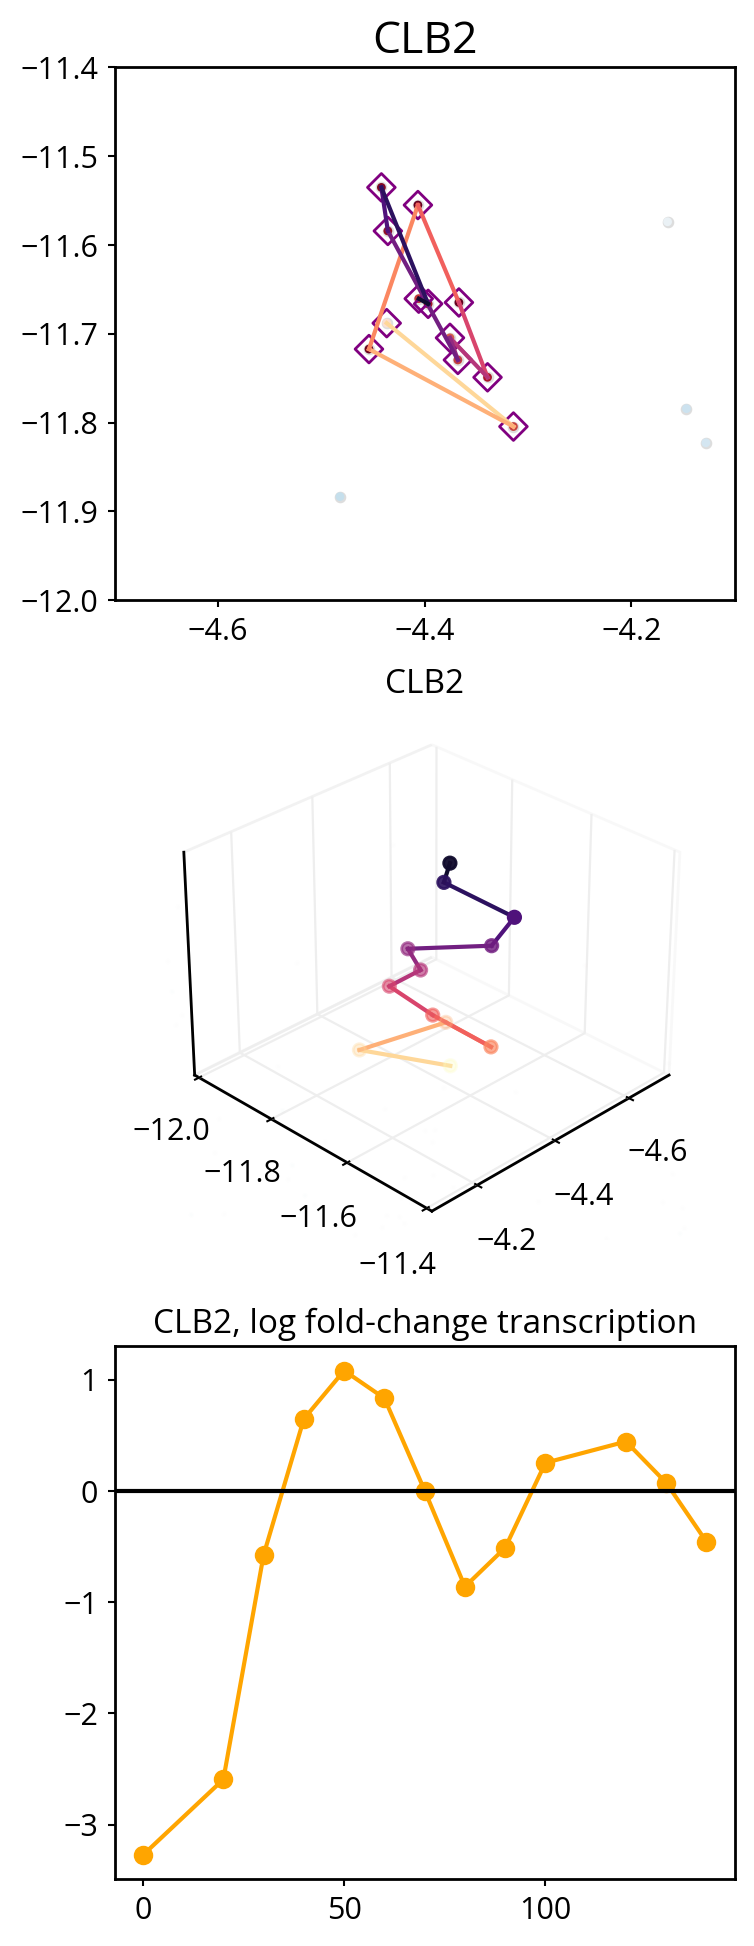

In [826]:
gene_name = 'CLB2'

plot_atts_raw(gene_name)
plot_timecourse(gene_name)
plot_timecourse(gene_name, xlim=(-4.7, -4.1), ylim=(-12, -11.4))

In [960]:
i = 0
for gene_name in mean_dist_2.sort_values('max_autocorr', ascending=False)['name'].head(20):
    print(i, gene_name)
    fig = plot_atts_raw(gene_name, index=i)
    plt.close(fig)
    
    fig = plot_timecourse(gene_name, i=i)
    plt.close(fig)

    plt.cla()
    plt.clf()
    i += 1


0 STH1
Directory exists. Skipping.
Directory exists. Skipping.
1 GPR1
Directory exists. Skipping.
Directory exists. Skipping.
2 SPC24
Directory exists. Skipping.
Directory exists. Skipping.
3 SET2
Directory exists. Skipping.
Directory exists. Skipping.
4 DDR48
Directory exists. Skipping.
Directory exists. Skipping.
5 YME1
Directory exists. Skipping.
Directory exists. Skipping.
6 LYS14
Directory exists. Skipping.
Directory exists. Skipping.
7 BCP1
Directory exists. Skipping.
Directory exists. Skipping.
8 RVB1
Directory exists. Skipping.
Directory exists. Skipping.
9 SEC24
Directory exists. Skipping.
Directory exists. Skipping.
10 NDD1
Directory exists. Skipping.
Directory exists. Skipping.
11 BOR1
Directory exists. Skipping.
Directory exists. Skipping.
12 DBF4
Directory exists. Skipping.
Directory exists. Skipping.
13 NPT1
Directory exists. Skipping.
Directory exists. Skipping.
14 CST6
Directory exists. Skipping.
Directory exists. Skipping.
15 GUP2
Directory exists. Skipping.
Directory 

<Figure size 600x400 with 0 Axes>

In [927]:
for gene_name in mean_dist_2.sort_values('tpm_autocorr')['name'].tail(5):
    print(gene_name)
    fig = plot_atts_raw(gene_name)
    plt.close(fig)
    
    fig = plot_timecourse(gene_name)
    plt.close(fig)

    plt.cla()
    plt.clf()

PCL9
Directory exists. Skipping.
Directory exists. Skipping.
DSE4
Directory exists. Skipping.
Directory exists. Skipping.
HO
Directory exists. Skipping.
Directory exists. Skipping.
PIR1
Directory exists. Skipping.
Directory exists. Skipping.
EGT2
Directory exists. Skipping.
Directory exists. Skipping.


<Figure size 600x400 with 0 Axes>

In [926]:
mean_dist_2.sort_values('tpm_autocorr')

max_autocorr     name  tpm_autocorr
index                                       
YCR017C    761.310714    CWH43      0.012013
YBR235W    124.097945  YBR235W      0.012392
YNR052C     38.726587     POP2      0.013115
YER107C     14.829049     GLE2      0.014225
YFR048W      3.626749     RMD8      0.015398
...               ...      ...           ...
YDL179W     12.934424     PCL9     36.957629
YNR067C    136.825501     DSE4     41.316620
YDL227C      1.833204       HO     48.921715
YKL164C    141.661188     PIR1     61.777727
YNL327W    401.789465     EGT2     65.521977

[4427 rows x 3 columns]

Text(0.5, 1.0, 'Max chromatin autocorrelation')

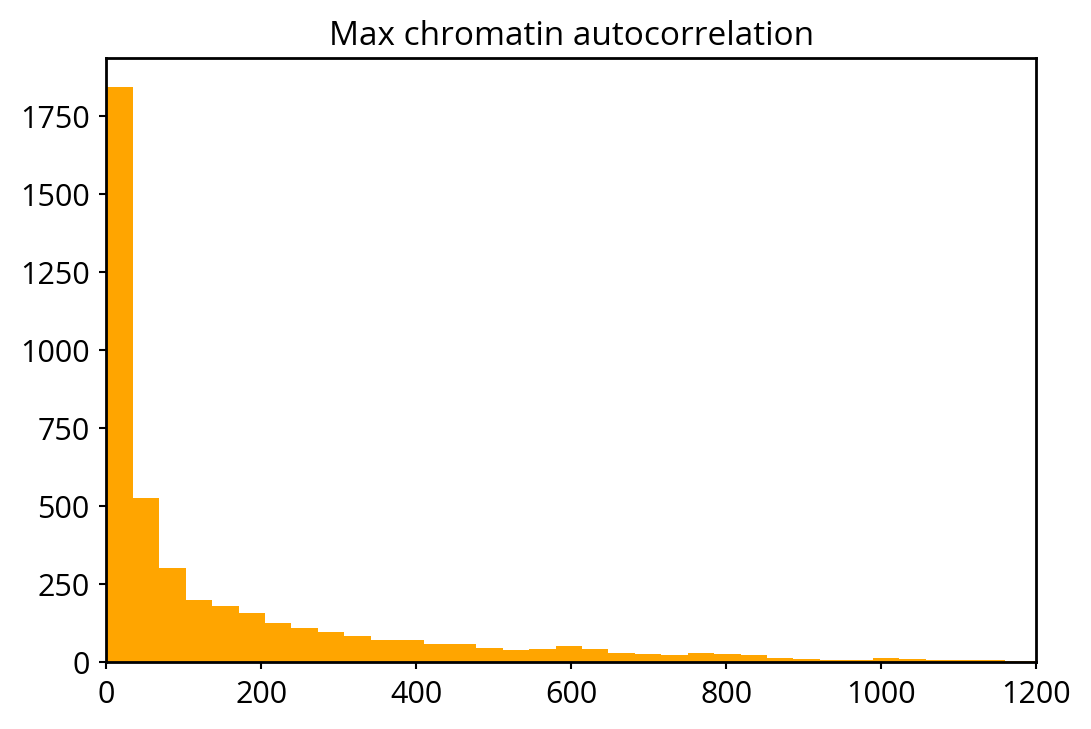

In [949]:
plt.hist(mean_dist_2.max_autocorr, bins=80, color='orange')
plt.xlim(0, 1200)
plt.title('Max chromatin autocorrelation')

Text(0.5, 1.0, 'Max lfc TPM autocorrelation')

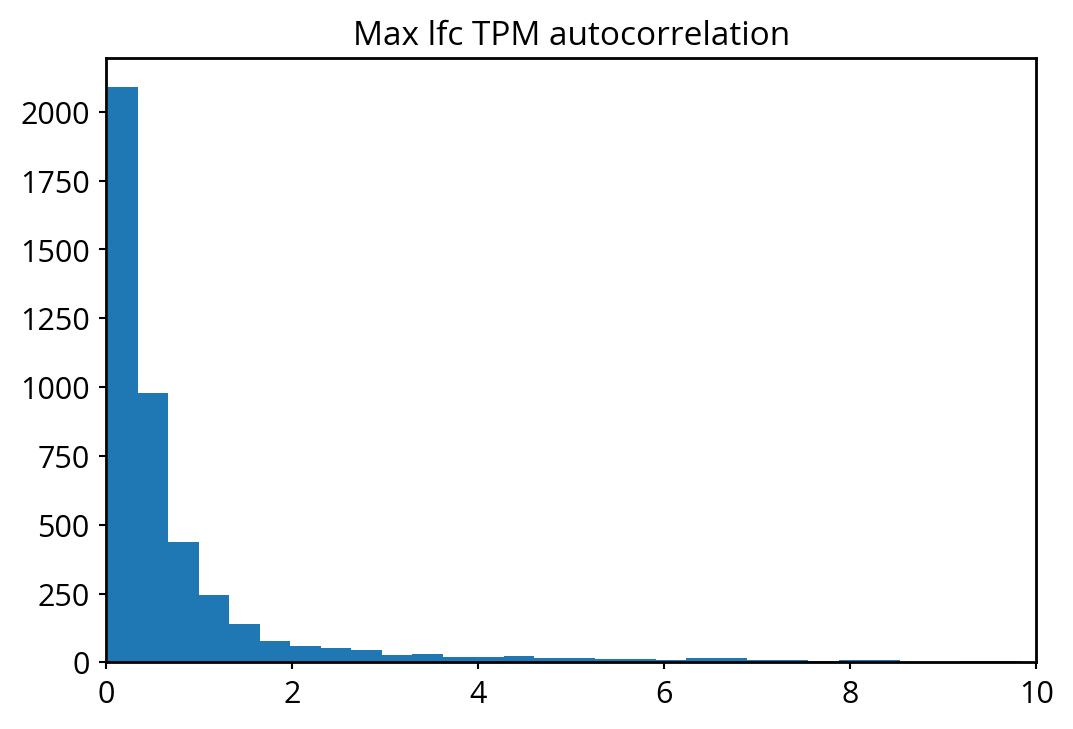

In [951]:
plt.hist(mean_dist_2.tpm_autocorr, bins=200)
plt.xlim(0, 10)
plt.title('Max lfc TPM autocorrelation')